In [1]:
import catboost
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from catboost import Pool, CatBoostRegressor, CatBoostClassifier, cv
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pylab import rcParams
from mlxtend.preprocessing import DenseTransformer

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


# matplotlib settings
matplotlib.style.use('ggplot')
rcParams['figure.figsize'] = 12, 8
rcParams['font.size'] = 12
rcParams['axes.facecolor'] = 'white'

In [2]:
# ! pip install jupyternotify
%load_ext jupyternotify

<IPython.core.display.Javascript object>

## Loading the data

In [3]:
data = pd.read_csv('../data/housing_russia/train.csv')
data.head(2)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000


### Data cleaning and new feature creation

In [4]:
data = data[data.full_sq < 5000]
data = data[data.life_sq < 5000]
data = data[(data.build_year < 2017) & (data.build_year > 1700)]

In [5]:
df_train, df_test, y_train, y_test = train_test_split(data, data.price_doc, test_size = 0.2,
                                                     shuffle = True)
df_train.is_copy = False
df_test.is_copy = False

## Exploratory Data Analysis
### Year train/test distribution

In [6]:
def split_timestamp(df):
    df.timestamp = pd.to_datetime(df.timestamp)
    df['day'] = df.timestamp.dt.day
    df['month'] = df.timestamp.dt.month
    df['year'] = df.timestamp.dt.year
    df['quarter'] = np.ceil(df['month'] / 3).astype(int)

split_timestamp(df_train)
split_timestamp(df_test)

In [7]:
year_train_distr = df_train.groupby(by = 'year')['timestamp'].count()
year_test_distr = df_test.groupby(by = 'year')['timestamp'].count()

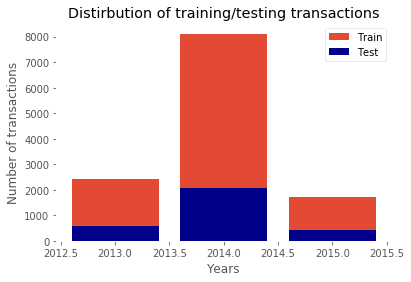

In [8]:
fig = plt.figure()
p2 = plt.bar(year_train_distr.index, year_train_distr)
p1 = plt.bar(year_test_distr.index, year_test_distr, color='darkblue')
plt.xlabel('Years')
plt.ylabel('Number of transactions')
plt.title('Distirbution of training/testing transactions')
plt.legend((p2[0], p1[0]), ('Train', 'Test'))
plt.show()

### Median price changes

In [9]:
price_train_distr = df_train.groupby(['year', 'quarter'])['price_doc'].median().reset_index()
price_train_distr['quarter_year'] = price_train_distr[['quarter', 'year']].apply(lambda (x, y): 
                                                                             str(x) + '-' + str(y), axis=1)
price_train_distr.head(2)

,year,quarter,price_doc,quarter_year
0,2013,2,6737500,2-2013
1,2013,3,6700000,3-2013


In [10]:
df_train['price_sq_m'] = df_train['price_doc'] / df_train['full_sq']
price_sq_m_train_distr = df_train.groupby(['year', 'quarter'])['price_sq_m'].median().reset_index()
price_sq_m_train_distr['quarter_year'] = price_sq_m_train_distr[['quarter', 'year']].apply(lambda (x, y): 
                                                                             str(x) + '-' + str(y), axis=1)
price_sq_m_train_distr.head(2)

,year,quarter,price_sq_m,quarter_year
0,2013,2,159990.530303,2-2013
1,2013,3,150362.150939,3-2013


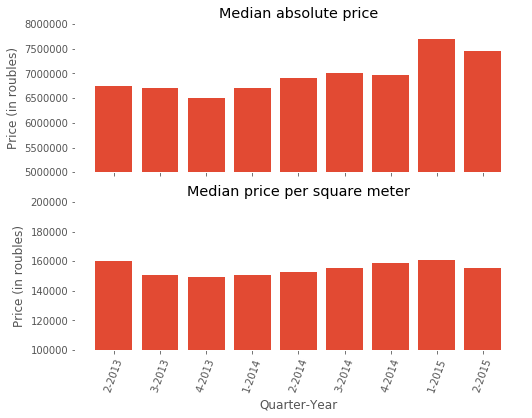

In [11]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (8, 6))
ax[0].bar(range(0, len(price_train_distr)), price_train_distr.price_doc)
ax[0].set_ylim(5e+6, 8e+6)
ax[0].set_xticks(range(0, len(price_train_distr)))
ax[0].set_xticklabels(price_train_distr.quarter_year, rotation=70)
ax[0].set_title('Median absolute price')
ax[0].set_ylabel('Price (in roubles)')


ax[1].bar(range(0, len(price_sq_m_train_distr)), price_sq_m_train_distr.price_sq_m)
ax[1].set_ylim(1e+5, 2e+5)
ax[1].set_xticks(range(0, len(price_sq_m_train_distr)))
ax[1].set_xticklabels(price_sq_m_train_distr.quarter_year, rotation=70)
ax[1].set_title('Median price per square meter')
ax[1].set_ylabel('Price (in roubles)')
ax[1].set_xlabel('Quarter-Year')

plt.show()

### Price dependency on total and living areas in square meters

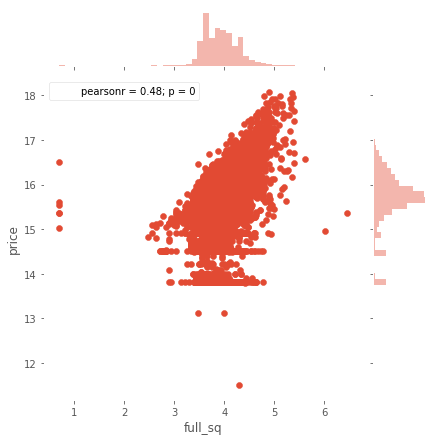

In [12]:
sns.jointplot(x=np.log1p(df_train.full_sq.values), y=np.log1p(df_train.price_doc.values)) \
   .set_axis_labels('full_sq', 'price')
plt.show()

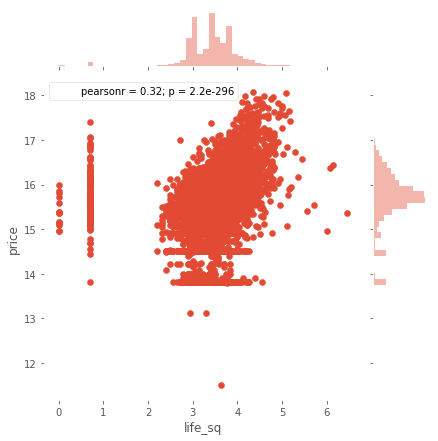

In [13]:
sns.jointplot(x=np.log1p(df_train.life_sq.values), y=np.log1p(df_train.price_doc.values)) \
   .set_axis_labels('life_sq', 'price')
plt.show()

### Floor and room number distribution

In [14]:
floor_unique = sorted(df_train.floor.dropna().unique())

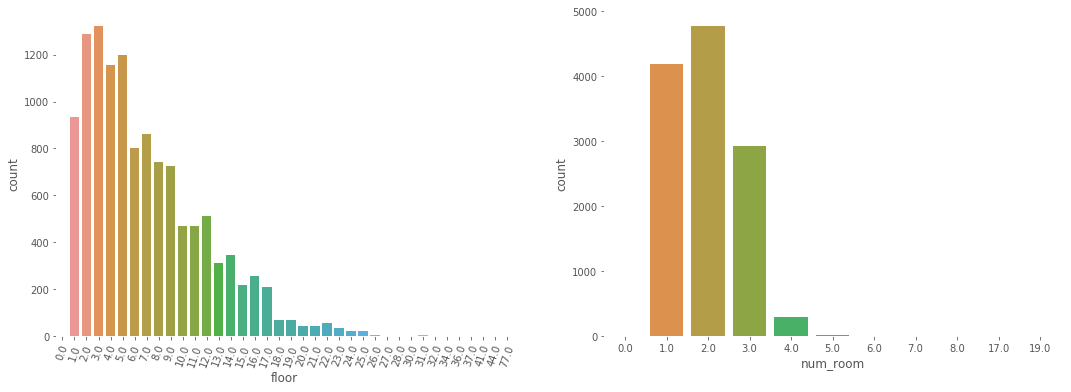

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
sns.countplot(x = "floor", data=df_train, ax = ax[0])
sns.countplot(x = "num_room", data = df_train, ax = ax[1])
ax[0].set_xticklabels(floor_unique, rotation=70)
plt.show()

#### Price difference between flats for Investment and for OwnerOccupiers

In [16]:
invest = df_train[df_train.product_type == 'Investment']
owner = df_train[df_train.product_type == 'OwnerOccupier']

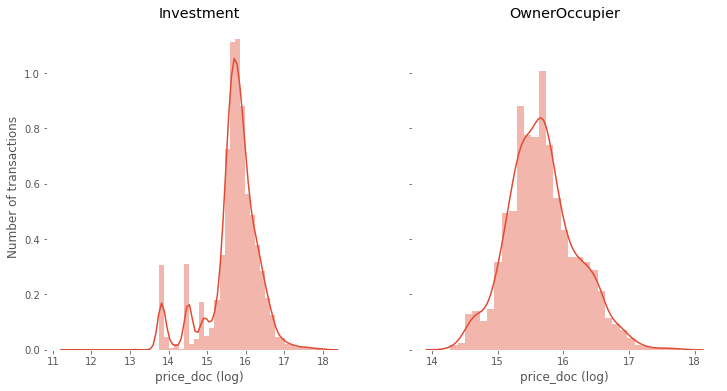

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6), sharey = True)
sns.distplot(np.log1p(invest.price_doc), ax = ax[0], axlabel = 'price_doc (log)')
sns.distplot(np.log1p(owner.price_doc), ax = ax[1], axlabel = 'price_doc (log)')
ax[0].set_title('Investment')
ax[1].set_title('OwnerOccupier')
ax[0].set_ylabel('Number of transactions')
plt.show()

### Build year distribution 

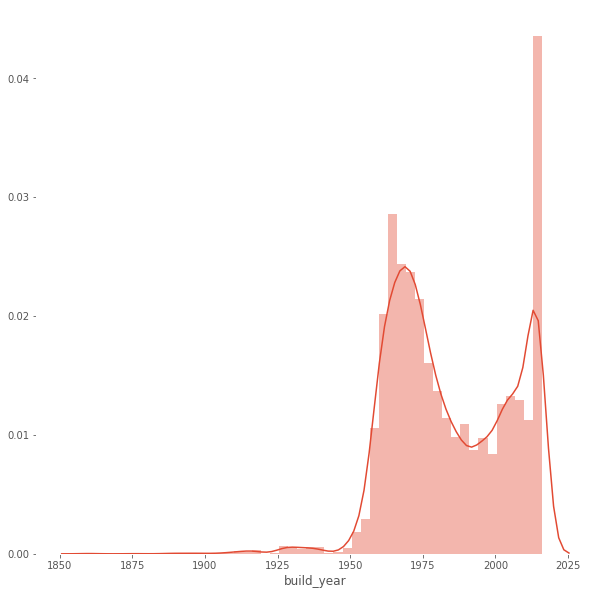

In [18]:
plt.figure(figsize=(10, 10))
sns.distplot(df_train.build_year.dropna())
plt.show()

In [19]:
# run once only
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)
id_test = df_test['id']

df_train = df_train.drop(['price_doc', 'price_sq_m', 'timestamp', 'id'], axis = 1)
df_test = df_test.drop(['timestamp', 'id'], axis = 1)

# Catboost: training and evaluating

RMSLE is chosen as our primary evaluation metric. 

The easiest way to use it is to use already implemented in most of the libraries metric RMSE on the $\ln(1 + y)$, where $y$ is the actual price.

In [20]:
cat_features = list(df_train.select_dtypes(include=['object']).columns.values)
cat_features.extend(['floor', 'max_floor', 'num_room'])
df_train[cat_features] = df_train[cat_features].astype(str)
df_test[cat_features] = df_test[cat_features].astype(str)

cat_indices = [df_train.columns.get_loc(name) for name in cat_features]

In [21]:
pool_train = Pool(df_train, label = y_train, cat_features=cat_indices)
pool_test = Pool(df_test, cat_features=cat_indices)

In [22]:
%%notify
model = CatBoostRegressor(learning_rate = 0.1, loss_function = 'RMSE', 
                          custom_metric = 'RMSE',  calc_feature_importance = True)
model.fit(pool_train, logging_level='Silent')

<IPython.core.display.Javascript object>

In [23]:
w = catboost.CatboostIpythonWidget('/project/eda')
w.update_widget()

CatboostIpythonWidget(data={'/project/eda': {'content': {'rows': {'learn_error': [['iter', 'RMSE', 'RMSE'], ['0', '14.14663462', '14.14663462'], ['1', '12.74114746', '12.74114746'], ['2', '11.4756453', '11.4756453'], ['3', '10.33629274', '10.33629274'], ['4', '9.307232912', '9.307232912'], ['5', '8.383134436', '8.383134436'], ['6', '7.550382367', '7.550382367'], ['7', '6.80381858', '6.80381858'], ['8', '6.132082375', '6.132082375'], ['9', '5.527525738', '5.527525738'], ['10', '4.983024879', '4.983024879'], ['11', '4.496238842', '4.496238842'], ['12', '4.058533546', '4.058533546'], ['13', '3.662643425', '3.662643425'], ['14', '3.308644567', '3.308644567'], ['15', '2.989951794', '2.989951794'], ['16', '2.704449676', '2.704449676'], ['17', '2.449313452', '2.449313452'], ['18', '2.221237398', '2.221237398'], ['19', '2.017092514', '2.017092514'], ['20', '1.83412459', '1.83412459'], ['21', '1.671514574', '1.671514574'], ['22', '1.527712025', '1.527712025'], ['23', '1.400090795', '1.400090795'], ['24', '1.28675182', '1.28675182'], ['25', '1.185598723', '1.185598723'], ['26', '1.098361129', '1.098361129'], ['27', '1.018293847', '1.018293847'], ['28', '0.9481937744', '0.9481937744'], ['29', '0.8885049447', '0.8885049447'], ['30', '0.8347987887', '0.8347987887'], ['31', '0.7888323237', '0.7888323237'], ['32', '0.7495183641', '0.7495183641'], ['33', '0.7149449937', '0.7149449937'], ['34', '0.6854847512', '0.6854847512'], ['35', '0.6608152339', '0.6608152339'], ['36', '0.6397972429', '0.6397972429'], ['37', '0.6212179459', '0.6212179459'], ['38', '0.6059249193', '0.6059249193'], ['39', '0.5924856745', '0.5924856745'], ['40', '0.582335268', '0.582335268'], ['41', '0.5734939816', '0.5734939816'], ['42', '0.5657611182', '0.5657611182'], ['43', '0.5598380895', '0.5598380895'], ['44', '0.5541598644', '0.5541598644'], ['45', '0.5496871997', '0.5496871997'], ['46', '0.5462841398', '0.5462841398'], ['47', '0.5431171553', '0.5431171553'], ['48', '0.5401935155', '0.5401935155'], ['49', '0.5378464058', '0.5378464058'], ['50', '0.53661322', '0.53661322'], ['51', '0.5350881784', '0.5350881784'], ['52', '0.5330954917', '0.5330954917'], ['53', '0.5314788226', '0.5314788226'], ['54', '0.5305167379', '0.5305167379'], ['55', '0.529299719', '0.529299719'], ['56', '0.5283157329', '0.5283157329'], ['57', '0.5271299005', '0.5271299005'], ['58', '0.5266661568', '0.5266661568'], ['59', '0.5261996076', '0.5261996076'], ['60', '0.5256172546', '0.5256172546'], ['61', '0.525050355', '0.525050355'], ['62', '0.5246310018', '0.5246310018'], ['63', '0.5243547225', '0.5243547225'], ['64', '0.5240303705', '0.5240303705'], ['65', '0.5233919165', '0.5233919165'], ['66', '0.5228588013', '0.5228588013'], ['67', '0.5226167061', '0.5226167061'], ['68', '0.5222347778', '0.5222347778'], ['69', '0.5219485199', '0.5219485199'], ['70', '0.5219247783', '0.5219247783'], ['71', '0.5213136987', '0.5213136987'], ['72', '0.5208561989', '0.5208561989'], ['73', '0.5201637', '0.5201637'], ['74', '0.5201236921', '0.5201236921'], ['75', '0.5197909328', '0.5197909328'], ['76', '0.5196627812', '0.5196627812'], ['77', '0.5196211255', '0.5196211255'], ['78', '0.5195674971', '0.5195674971'], ['79', '0.519553475', '0.519553475'], ['80', '0.5195314735', '0.5195314735'], ['81', '0.5192756814', '0.5192756814'], ['82', '0.5188866228', '0.5188866228'], ['83', '0.5185722238', '0.5185722238'], ['84', '0.5185537603', '0.5185537603'], ['85', '0.5184929838', '0.5184929838'], ['86', '0.51849162', '0.51849162'], ['87', '0.5179723042', '0.5179723042'], ['88', '0.5175339585', '0.5175339585'], ['89', '0.5170258193', '0.5170258193'], ['90', '0.5168437249', '0.5168437249'], ['91', '0.5167933069', '0.5167933069'], ['92', '0.5167590549', '0.5167590549'], ['93', '0.5166935133', '0.5166935133'], ['94', '0.5166055963', '0.5166055963'], ['95', '0.5163668326', '0.5163668326'], ['96', '0.5157164264', '0.5157164264'], ['97', '0.5156597083', '0.5156597083'], ['98', '0.5155309991', '0.5155309991'], ['99', '0.5155211581', '0.51

### Evaluation

In [24]:
y_pred = model.predict(pool_test)
print("RMLSE on test set = %f" % np.sqrt(mean_squared_error(y_test, y_pred)))

RMLSE on test set = 0.517680


In [ ]:
%%notify
cv_params = model.get_params()
cv_params['logging_level'] = 'Silent'
del cv_params['calc_feature_importance']
cv_data = cv(cv_params, Pool(df_train, y_train, cat_features=cat_indices), 
             fold_count=3, shuffle = True)

In [28]:
cv_data['RMSE_test_avg'][-1]

### Feature importance

In [ ]:
def plot_top_features(model, pool, num):
    top = sorted(zip(pool.get_feature_names(), model.feature_importances_),
                  key = lambda x: x[1], reverse = True)[:num]
    top = sorted(top, key = lambda x: x[1])
    plot_top = zip(*top)
    plt.figure()
    plt.barh(range(0, len(plot_top[0])), plot_top[1], tick_label = plot_top[0])
    plt.title('Feature importance')
    plt.show()
    return top
    

top_features = plot_top_features(model, pool_train, 20)

### Kaggle submission

In [ ]:
y_pred = np.expm1(model.predict(pool_test))

In [ ]:
filename = 'catboost_no_macro.txt'
submit = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
submit.price_doc = submit.price_doc.map('{:.2f}'.format)
submit.to_csv(filename, sep = ',', index = None)

# XGBoost

In [ ]:
df_train = pd.get_dummies(df_train, columns = cat_features)

In [ ]:
xgboost_clf = Pipeline([('to_dense', DenseTransformer()), 
                        ('clf', xgb.XGBRegressor())])

In [ ]:
cv = cross_val_score(xgboost_clf, df_train, y_train, scoring='neg_mean_squared_error', cv=3, n_jobs = -1, verbose=True)

In [ ]:
np.sqrt(-cv.mean())